In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np

f = open('ds/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

In [51]:
# split the dataset according to folding number
train_idx = (foldlist <= 6)
valid_idx = (foldlist == 7)
stack_idx = (foldlist == 8)
test_idx  = (foldlist == 9)

In [52]:
# compute the appearances of each feature
name_feature, name_feature_cnt = [], []
for i in range(len(namelist[train_idx])):
    for j in range(len(namelist[train_idx][i])):
        if namelist[train_idx][i][j] not in name_feature:
            name_feature.append(namelist[train_idx][i][j])
            name_feature_cnt.append(1)
        else:
            idx = name_feature.index(namelist[train_idx][i][j])
            name_feature_cnt[idx] += 1
    if len(namelist[train_idx][i]) > 1:
        if namelist[train_idx][i] not in name_feature:
            name_feature.append(namelist[train_idx][i])
            name_feature_cnt.append(1)
        else:
            idx = name_feature.index(namelist[train_idx][i])
            name_feature_cnt[idx] += 1

# remove the feature with less than 2 appearances
i = 0
while i < len(name_feature):
    if name_feature_cnt[i] < 2:
        del name_feature[i]
        del name_feature_cnt[i]
        i -= 1
    i += 1

name_feature.append("_Other_Feature_")

In [53]:
x_train = np.zeros((len(namelist[train_idx]), len(name_feature)))
x_valid = np.zeros((len(namelist[valid_idx]), len(name_feature)))
x_stack = np.zeros((len(namelist[stack_idx]), len(name_feature)))
x_test  = np.zeros((len(namelist[test_idx]), len(name_feature)))

y_train = sexlist[train_idx]
y_valid = sexlist[valid_idx]
y_stack = sexlist[stack_idx]
y_test  = sexlist[test_idx]

# construct x_train
for i in range(len(namelist[train_idx])):
    other = 1
    for j in range(len(namelist[train_idx][i])):
        if namelist[train_idx][i][j] in name_feature:
            idx = name_feature.index(namelist[train_idx][i][j])
            x_train[i][idx] = 1
        else:
            other = 0
    if len(namelist[train_idx][i]) > 1:
        if namelist[train_idx][i] in name_feature:
            idx = name_feature.index(namelist[train_idx][i])
            x_train[i][idx] = 1
        else:
            other = 0
    if other == 0:
        x_train[i][-1] = 1

# construct x_valid
for i in range(len(namelist[valid_idx])):
    other = 1
    for j in range(len(namelist[valid_idx][i])):
        if namelist[valid_idx][i][j] in name_feature:
            idx = name_feature.index(namelist[valid_idx][i][j])
            x_valid[i][idx] = 1
        else:
            other = 0
    if len(namelist[valid_idx][i]) > 1:
        if namelist[valid_idx][i] in name_feature:
            idx = name_feature.index(namelist[valid_idx][i])
            x_valid[i][idx] = 1
        else:
            other = 0
    if other == 0:
        x_valid[i][-1] = 1

# construct x_stack
for i in range(len(namelist[stack_idx])):
    other = 1
    for j in range(len(namelist[stack_idx][i])):
        if namelist[stack_idx][i][j] in name_feature:
            idx = name_feature.index(namelist[stack_idx][i][j])
            x_stack[i][idx] = 1
        else:
            other = 0
    if len(namelist[stack_idx][i]) > 1:
        if namelist[stack_idx][i] in name_feature:
            idx = name_feature.index(namelist[stack_idx][i])
            x_stack[i][idx] = 1
        else:
            other = 0
    if other == 0:
        x_stack[i][-1] = 1

# construct x_test
for i in range(len(namelist[test_idx])):
    other = 1
    for j in range(len(namelist[test_idx][i])):
        if namelist[test_idx][i][j] in name_feature:
            idx = name_feature.index(namelist[test_idx][i][j])
            x_test[i][idx] = 1
        else:
            other = 0
    if len(namelist[test_idx][i]) > 1:
        if namelist[test_idx][i] in name_feature:
            idx = name_feature.index(namelist[test_idx][i])
            x_test[i][idx] = 1
        else:
            other = 0
    if other == 0:
        x_test[i][-1] = 1

print("x_train shape = ", x_train.shape)
print("y_train shape = ", y_train.shape)
print("x_valid shape = ", x_valid.shape)
print("y_valid shape = ", y_valid.shape)
print("x_stack shape = ", x_stack.shape)
print("y_stack shape = ", y_stack.shape)
print("x_test shape  = ", x_test.shape)
print("y_test shape  = ", y_test.shape)

x_train shape =  (7483, 1630)
y_train shape =  (7483,)
x_valid shape =  (1110, 1630)
y_valid shape =  (1110,)
x_stack shape =  (1073, 1630)
y_stack shape =  (1073,)
x_test shape  =  (1064, 1630)
y_test shape  =  (1064,)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score
def accuracy(ypred, y_test):
    acc = 1 - np.mean(np.abs(ypred - y_test))
    return acc

grid = np.zeros(20)
for i in range(len(grid)):
    if i == 0:
        grid[i] = 0.0001
    else:
        grid[i] = grid[i-1]*pow(10000000, 1/19)

for i in range(len(grid)):
    lr = LogisticRegression(solver = 'newton-cg', C = grid[i], max_iter = 1000, fit_intercept = False)
    lr.fit(x_train, y_train)
    ypred = lr.predict(x_valid)
    print("grid = "+str(grid[i])+", F1 score = "+str(f1_score(y_valid, ypred)))

grid = 0.0001, F1 score = 0.7552552552552553
grid = 0.00023357214690901222, F1 score = 0.7693486590038313
grid = 0.0005455594781168519, F1 score = 0.7926926131850677
grid = 0.0012742749857031339, F1 score = 0.8249158249158248
grid = 0.0029763514416313182, F1 score = 0.8543516873889875
grid = 0.0069519279617756054, F1 score = 0.8638838475499092
grid = 0.016237767391887217, F1 score = 0.8723599632690542
grid = 0.037926901907322494, F1 score = 0.882899628252788
grid = 0.08858667904100825, F1 score = 0.8930581613508444
grid = 0.20691380811147894, F1 score = 0.8955785512699905
grid = 0.48329302385717526, F1 score = 0.8934967012252593
grid = 1.1288378916846888, F1 score = 0.8945386064030133
grid = 2.6366508987303576, F1 score = 0.8970727101038716
grid = 6.158482110660262, F1 score = 0.8949858088930936
grid = 14.384498882876622, F1 score = 0.8987701040681173
grid = 33.59818286283781, F1 score = 0.8981132075471698
grid = 78.4759970351461, F1 score = 0.8989612842304061
grid = 183.2980710832435,

In [17]:
bestc = 78.4759970351461
x_train_valid = np.concatenate((x_train, x_valid))
y_train_valid = np.concatenate((y_train, y_valid))
lr = LogisticRegression(solver = 'newton-cg', C = bestc, max_iter = 1000, fit_intercept = False)
lr.fit(x_train_valid, y_train_valid)
ypred = lr.predict(x_test)
print("grid = "+str(bestc))
print("test Accuracy = "+str(accuracy(ypred, y_test)))
print("test F1-score = "+str(f1_score(y_test, ypred)))
print("test Precision = "+str(precision_score(y_test, ypred)))
print("test Recall = "+str(recall_score(y_test, ypred)))

grid = 78.4759970351461
test Accuracy = 0.8853383458646616
test F1-score = 0.8775100401606427
test Precision = 0.8585461689587426
test Recall = 0.8973305954825462


In [44]:
np.set_printoptions(suppress=True)
coef = np.abs(lr.coef_)
w = np.sort(coef)[::-1]
print(w)

[[0.00002301 0.00004163 0.00004716 ... 8.48157782 8.84829025 9.40048552]]


In [85]:
from sklearn.ensemble import RandomForestClassifier
grid = np.zeros(10)
for i in range(len(grid)):
    if i == 0:
        grid[i] = 5
    else:
        grid[i] = grid[i-1]*pow(200, 1/9)
grid = np.around(grid)
for i in range(len(grid)):
    clf = RandomForestClassifier(n_estimators=int(grid[i]))
    clf.fit(x_train, y_train)
    ypred = clf.predict(x_valid)
    print("grid = "+str(int(grid[i]))+", F1 score = "+str(f1_score(y_valid, ypred)))

grid = 5, F1 score = 0.8607108549471661
grid = 9, F1 score = 0.8455598455598456
grid = 16, F1 score = 0.8527430221366699
grid = 29, F1 score = 0.870722433460076
grid = 53, F1 score = 0.862559241706161
grid = 95, F1 score = 0.8590733590733591
grid = 171, F1 score = 0.8651252408477842
grid = 308, F1 score = 0.8664745437079733
grid = 555, F1 score = 0.861003861003861
grid = 1000, F1 score = 0.8675623800383878


In [88]:
best_nest = 29
clf = RandomForestClassifier(n_estimators=best_nest)
clf.fit(x_train_valid, y_train_valid)
ypred = clf.predict(x_test)
print("grid = "+str(best_nest))
print("test Accuracy = "+str(accuracy(ypred, y_test)))
print("test F1-score = "+str(f1_score(y_test, ypred)))
print("test Precision = "+str(precision_score(y_test, ypred)))
print("test Recall = "+str(recall_score(y_test, ypred)))

grid = 29
test Accuracy = 0.8308270676691729
test F1-score = 0.8178137651821861
test Precision = 0.8063872255489022
test Recall = 0.8295687885010267


In [7]:
from sklearn.ensemble import GradientBoostingClassifier
grid = np.zeros(15, dtype=int)
for i in range(len(grid)):
    if i == 0:
        grid[i] = 100
    else:
        grid[i] = grid[i-1]+100

f1 = [[], [], []]
lr = [0.1, 0.5, 1]
for i in range(len(lr)):
    for j in range(len(grid)):
        clf = GradientBoostingClassifier(learning_rate=lr[i], n_estimators=grid[j])
        clf.fit(x_train, y_train)
        ypred = clf.predict(x_valid)
        print("lr = "+str(lr[i])+", grid = "+str(grid[j])+", F1 score = "+str(f1_score(y_valid, ypred)))
        f1[i].append(f1_score(y_valid, ypred))

lr = 0.1, grid = 100, F1 score = 0.807631160572337
lr = 0.1, grid = 200, F1 score = 0.84006734006734
lr = 0.1, grid = 300, F1 score = 0.8654353562005277
lr = 0.1, grid = 400, F1 score = 0.8726625111308994
lr = 0.1, grid = 500, F1 score = 0.8799283154121863
lr = 0.1, grid = 600, F1 score = 0.888086642599278
lr = 0.1, grid = 700, F1 score = 0.8915223336371922
lr = 0.1, grid = 800, F1 score = 0.8956602031394274
lr = 0.1, grid = 900, F1 score = 0.9026876737720112
lr = 0.1, grid = 1000, F1 score = 0.9052044609665427
lr = 0.1, grid = 1100, F1 score = 0.9014869888475836
lr = 0.1, grid = 1200, F1 score = 0.9031657355679703
lr = 0.1, grid = 1300, F1 score = 0.9011194029850746
lr = 0.1, grid = 1400, F1 score = 0.8957169459962756
lr = 0.1, grid = 1500, F1 score = 0.9002795899347623
lr = 0.5, grid = 100, F1 score = 0.8742194469223907
lr = 0.5, grid = 200, F1 score = 0.9025069637883009
lr = 0.5, grid = 300, F1 score = 0.8957746478873239
lr = 0.5, grid = 400, F1 score = 0.8974600188146755
lr = 0.5, 

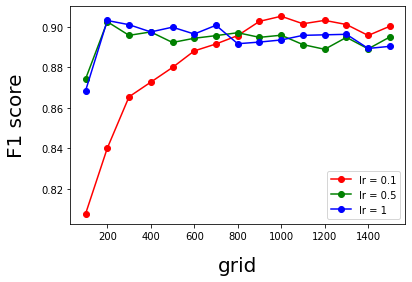

In [10]:
# plot the curves of three different learning rate
plt.plot(grid, f1[0], 'o-', color = 'r', label = 'lr = 0.1')
plt.plot(grid, f1[1], 'o-', color = 'g', label = 'lr = 0.5')
plt.plot(grid, f1[2], 'o-', color = 'b', label = 'lr = 1')
plt.xlabel("grid", fontsize=20, labelpad = 15)
plt.ylabel("F1 score", fontsize=20, labelpad = 15)
plt.legend()
plt.show()

In [13]:
best_lr = 0.1
best_nstg = 1000
clf = GradientBoostingClassifier(learning_rate=best_lr, n_estimators=best_nstg)
clf.fit(x_train_valid, y_train_valid)
ypred = clf.predict(x_test)
print("learning rate = "+str(best_lr))
print("stage = "+str(best_nstg))
print("test Accuracy = "+str(accuracy(ypred, y_test)))
print("test F1-score = "+str(f1_score(y_test, ypred)))
print("test Precision = "+str(precision_score(y_test, ypred)))
print("test Recall = "+str(recall_score(y_test, ypred)))

learning rate = 0.1
stage = 1000
test Accuracy = 0.868421052631579
test F1-score = 0.862475442043222
test Precision = 0.8267419962335216
test Recall = 0.9014373716632443


In [61]:
feat = np.sort(clf.feature_importances_)[::-1]
idx = list(map(list(clf.feature_importances_).index, feat[:20]))
print([name_feature[i] for i in idx])

['妤', '翔', '萱', '柏', '婷', '哲', '怡', '蓁', '承', '雅', '晴', '佳', '柔', '宜', '芸', '涵', '芷', '瑄', '慈', '庭']


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("In raw data, there are %d students and %d departments in total." % (nstuid, ndepid))

#construct the department-student matrix (i.e. array). 
dep_stu = np.zeros((ndepid, nstuid))
rowname = all_depid.copy()

depid_seq_map = dict()
for i in range(ndepid):
    depid_seq_map[all_depid[i]] = i

stuid_seq_map = dict()
for i in range(nstuid):
    stuid_seq_map[all_stuid[i]] = i

for cindex, row in stu_adm.iterrows():
    #print(cindex, row)
    dep_seq = depid_seq_map[row['department_id']]
    stu_seq = stuid_seq_map[row['student_id']]
    #print(dep_seq, stu_seq)
    dep_stu[dep_seq, stu_seq] = 1

#Remove very small departments.
min_stu_per_dep = 10
min_apply_dep_per_stu = 2

#remove small departments and single-application students. 
dep_apply_sum = np.sum(dep_stu, axis = 1)
keeprow = dep_apply_sum >= min_stu_per_dep
rowname = rowname[keeprow]
dep_stu2 = dep_stu[keeprow,:]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#another run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#third run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]

stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#check to make sure the two conditions are satisfied. 
dep_apply_sum = np.sum(dep_stu2, axis = 1)
print("Number of department too small:", np.sum(dep_apply_sum < min_stu_per_dep))
stu_apply_sum = np.sum(dep_stu2, axis = 0)
print("Number of students applying only one department:", np.sum(stu_apply_sum <min_apply_dep_per_stu))

#now both conditions are satisfied.

In raw data, there are 60461 students and 1976 departments in total.
Number of department too small: 0
Number of students applying only one department: 0


In [11]:
uname['depname'] = uname.school_name_abbr + uname.department_name_abbr
uname2 = uname[['department_id', 'depname', 'category_name']].copy()
#this is for later use, to color data points. 
category_id, category_levels = pd.factorize(uname2.category_name)
#uname2['category_id'] = category_id / np.max(category_id)
uname2['category_id'] = category_id

#create a data frame for column name
colname_df = pd.DataFrame({'department_id': rowname})
colname_df = colname_df.merge(uname2, how = "left", on="department_id")

In [12]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=8)
x_pca = pca.fit_transform(dep_stu2)
x = pd.concat([pd.DataFrame(x_pca), colname_df['category_name']], axis=1)

In [13]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

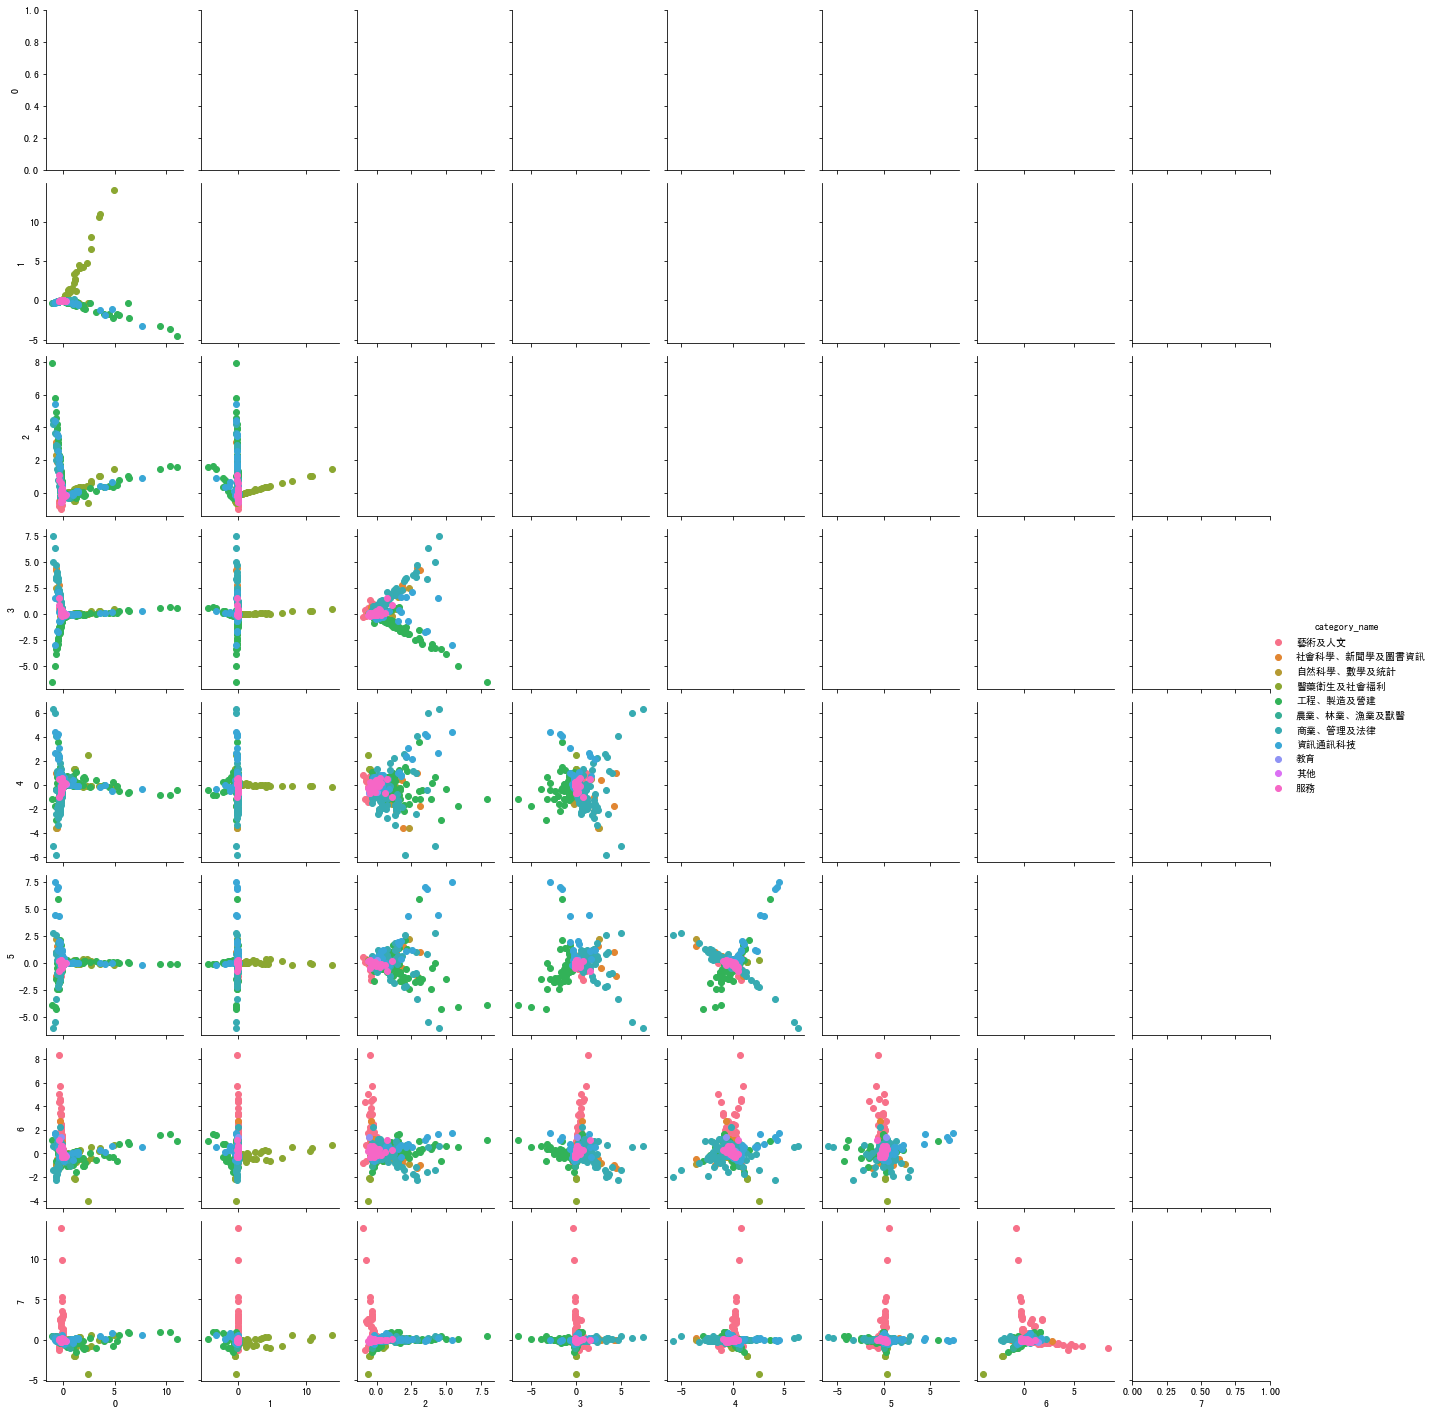

In [14]:
g = sns.PairGrid(x, hue='category_name')
g.map_lower(plt.scatter)
g.add_legend()
g.fig.set_size_inches(20,20)

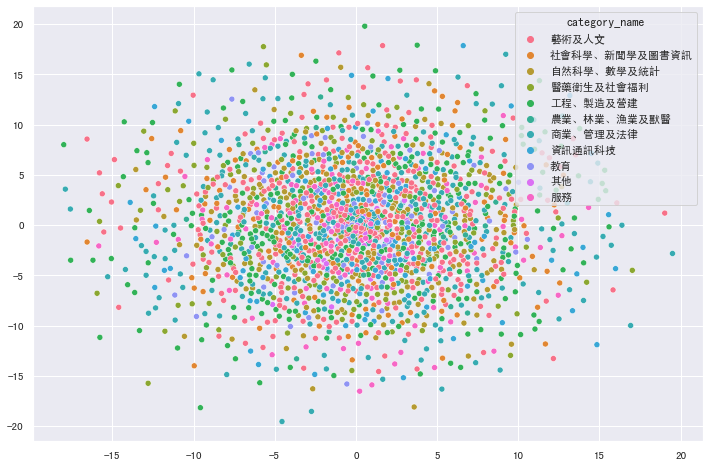

In [42]:
from sklearn.manifold import MDS
metric = MDS()
x_metric = metric.fit_transform(dep_stu2)
sns.scatterplot(x=x_metric[:,0], y=x_metric[:,1], hue=colname_df['category_name'])

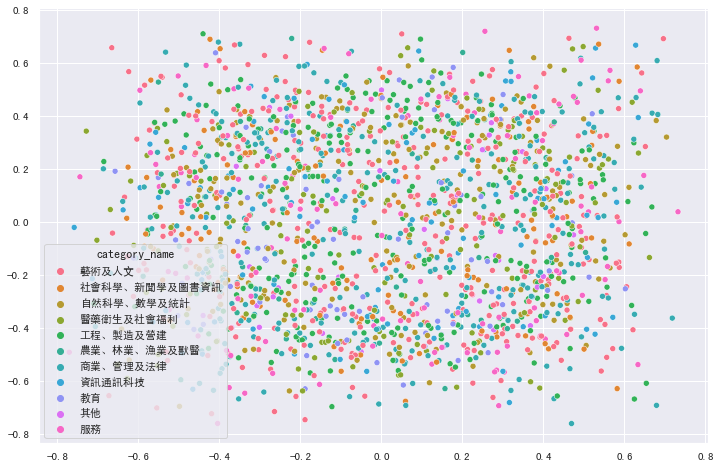

In [45]:
non_metric = MDS(metric=False)
x_non_metric = non_metric.fit_transform(dep_stu2)
sns.scatterplot(x=x_non_metric[:,0], y=x_non_metric[:,1], hue=colname_df['category_name'])

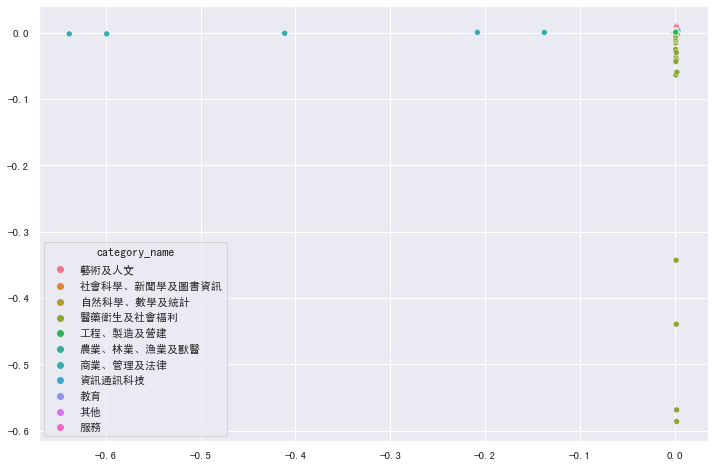

In [46]:
from sklearn.manifold import LocallyLinearEmbedding
# 20 neighbor
lle_20 = LocallyLinearEmbedding(n_components=2,n_neighbors=20)
x_lle_20 = lle_20.fit_transform(dep_stu2)
sns.scatterplot(x=x_lle_20[:,0], y=x_lle_20[:,1], hue=colname_df['category_name'])

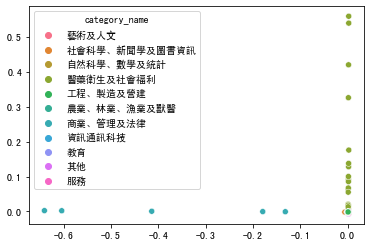

In [9]:
# 40 neighbor
lle_40 = LocallyLinearEmbedding(n_components=2,n_neighbors=40)
x_lle_40 = lle_40.fit_transform(dep_stu2)
sns.scatterplot(x=x_lle_40[:,0], y=x_lle_40[:,1], hue=colname_df['category_name'])

In [2]:
from sklearn.manifold import LocallyLinearEmbedding